# Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC

from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
    classification_report, confusion_matrix

import seaborn as sns
from time import time

import sys
sys.path.insert(0, '../titanic/')
import load_titanic_data 

import warnings
warnings.filterwarnings("ignore")

# Custom Functions

In [2]:
def findBestParams(training_features:np.ndarray, training_labels:np.ndarray, C = range(1, 51, 5), kernels = ('linear', 'poly', 'rbf', 'sigmoid'), degree = [2,3,4], cv:int = 5) ->dict:
    """
    This function prints the best hyperparameters for an SVM Model using grid search
    
    Parameters
    ----------
    training_features:np.ndarray
        training features used to find best hyperparameters
    training_labels:np.ndarray
        training labels used to find best hyperparameters
    C, optional
        a list, set or tuple of ints/floats for finding best
        regularization hyperparameter
    kernels, optional
        a list set or tuple of strings for all kernels to be tested
    degree, optional
        a list set or tuple of of all polynomial degrees to be tested
        for the polynomial kernel
    cv:int, optional
        number of (Stratified) K folds to perform for each  grid search 
    """
    
    parameters = {'kernel':kernels, 'C':C, 'degree':degree}
    clf = GridSearchCV(SVC(), parameters, cv = cv)
    clf.fit(training_features, training_labels)
    print("best hyperparameters:\t",clf.best_params_)
    print("best mean cross-validation score:\t",clf.best_score_)
    return clf.best_params_

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Custom SVM Classifier

In [3]:
class MySVMClassifier(SVC):
    """
    This SVM Model is a subclass of the SVM Classifier.
    In addition, this class can compute the time taken to train the model,
    print the accuracy and classification report, and plot the confusion matrix
    """
        
    def trainModel(self, train_features:np.ndarray, train_labels:np.ndarray):
        """
        The method trains the SVM model and computes the training time
        
        Parameters
        --------------
        train_features:np.ndarray
            features vector used for traning
        train_labels:np.ndarray
            labels vector for training
        """
        
        start_time = time()
        clf = self.fit(train_features, train_labels)
        end_time = time()
        print("Total Training Time:\t%.2fs" % (end_time - start_time))
        return clf
    
    def getTrainPerformance(self, train_features:np.ndarray, train_labels:np.ndarray) -> np.ndarray:
        """
        This method prints training accuracy, precision, recall and f1-score
        of the SVM model 
        
        Parameters
        --------------
        test_features:np.ndarray
            features vector used for traning
        test_labels:np.ndarray
            labels vector for training
        """
        
        predictions = self.predict(train_features)
        print("The Accuracy of the SVM model is:\t%.2f%%" % 
              (100 * accuracy_score(train_labels, predictions))
              )
        print("The Precision of the SVM model is:\t%.2f%%" % 
              (100 * precision_score(train_labels, predictions))
              )
        print("The Recall of the SVM model is:\t%.2f%%" % 
              (100 * recall_score(train_labels, predictions))
              )
        print("The F1-Score of the SVM model is:\t%.2f%%" % 
              (100 * f1_score(train_labels, predictions))
              )
        return predictions
        
        
    def getModelPerformance(self, test_features:np.ndarray, test_labels:np.ndarray) -> np.ndarray:
        """
        This method prints validation accuracy, precision, recall and f1-score
        of the SVM model 
        
        Parameters
        --------------
        test_features:np.ndarray
            features vector used for traning
        test_labels:np.ndarray
            labels vector for training
        """
        
        predictions = self.predict(test_features)
        print("The Accuracy of the SVM model is:\t%.2f%%" % 
              (100 * accuracy_score(test_labels, predictions))
              )
        print("The Precision of the SVM model is:\t%.2f%%" % 
              (100 * precision_score(test_labels, predictions))
              )
        print("The Recall of the SVM model is:\t%.2f%%" % 
              (100 * recall_score(test_labels, predictions))
              )
        print("The F1-Score of the SVM model is:\t%.2f%%" % 
              (100 * f1_score(test_labels, predictions))
              )
        return predictions
       
    def printReport(self, test_features:np.ndarray, test_labels:np.ndarray) -> None:
        """
        This method prints a classification report of the SVM Model
        
        Parameters
        --------------
        test_features:np.ndarray
            features vector used for traning
        test_labels:np.ndarray
            labels vector for training
        """
        
        predictions = self.predict(test_features)
        print("Here is the classification report of the SVM Model:")
        print(
            classification_report(
                test_labels, predictions, target_names = ["Did Not Survive", "Survived"]
            )
        )

    def plotConFusionMatrix(self, test_features:np.ndarray, test_labels:np.ndarray) -> None:
        """
        This method plots the confusion matrix of the SVM model
        
        Parameters
        --------------
        test_features:np.ndarray
            features vector used for traning
        test_labels:np.ndarray
            labels vector for training
        """
        
        predictions = self.predict(test_features)
        cm = confusion_matrix(test_labels, predictions)

        cm_df = pd.DataFrame(cm, index = {i for i in test_labels}, 
                             columns = {i for i in test_labels})
        plt.figure(figsize = (20,14))
        sns.set(font_scale = 2.5)
        sns.heatmap(cm_df, annot=True, annot_kws = {"size":40}, cmap="YlGnBu",
                    xticklabels = ["Did Not Survive", "Survived"],
                    yticklabels = ["Did Not Survive", "Survived"]
                    )
        
        plt.show()


# Plotting the correlation matrix


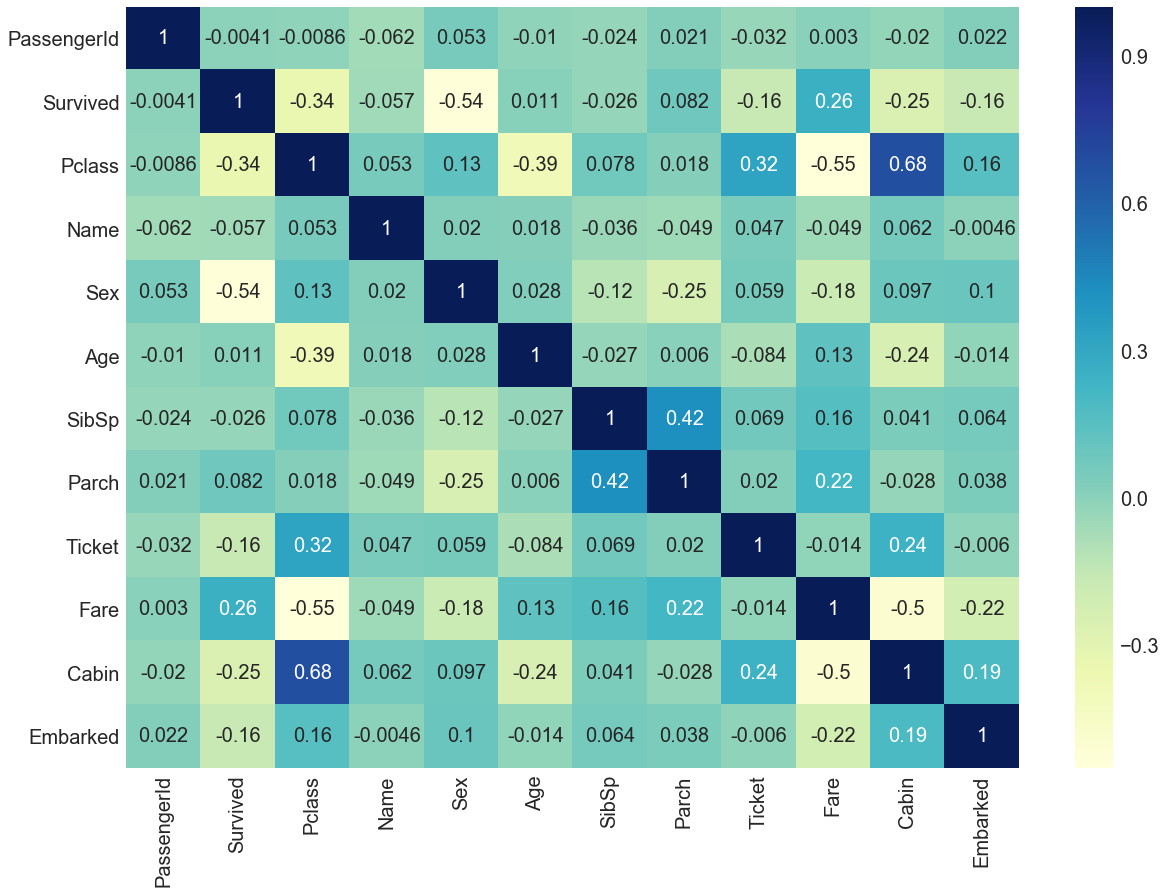

In [4]:
load_titanic_data.feature_correlation()

# Loading the training and testing data


In [5]:
# load data
exclude = {"PassengerId", "Name", "Fare", "Ticket", "Cabin"}
train_data = load_titanic_data.train_data(drop_columns = exclude)
test_data = load_titanic_data.test_data(drop_columns = exclude)


Training Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Survived    891 non-null int32
Pclass      891 non-null int32
Sex         891 non-null int32
Age         891 non-null int32
SibSp       891 non-null int32
Parch       891 non-null int32
Embarked    891 non-null int32
dtypes: int32(7)
memory usage: 24.4 KB
None

Testing Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
Pclass      418 non-null int32
Sex         418 non-null int32
Age         418 non-null int32
SibSp       418 non-null int32
Parch       418 non-null int32
Embarked    418 non-null int32
dtypes: int32(6)
memory usage: 9.9 KB
None


# Scaling the data before training the model

In [6]:
# scale the data before performing grid search
scaled_features = scale(train_data["features"])

# Finding the best hyperparameters

In [7]:
# find best parameters for SVM using grid search
best_params = findBestParams(scaled_features, train_data["labels"])

best hyperparameters:	 {'C': 1, 'degree': 2, 'kernel': 'poly'}
best mean cross-validation score:	 0.803577929822359


# Build the SVM model

In [8]:
# build SVM model based on best parameters
svm_model = MySVMClassifier(C = best_params['C'], kernel = best_params['kernel'], degree = best_params['degree'])

# Split data into training and validation set

In [9]:
# split data into training and validation set
train_features, validate_features, train_labels, validate_labels = train_test_split(
    scaled_features, train_data["labels"], random_state = 42, test_size = 0.1
)

# Train the SVM Model

In [10]:
# train model
svm_model.trainModel(train_features, train_labels)

Total Training Time:	0.03s


MySVMClassifier(C=1, break_ties=False, cache_size=200, class_weight=None,
                coef0=0.0, decision_function_shape='ovr', degree=2,
                gamma='scale', kernel='poly', max_iter=-1, probability=False,
                random_state=None, shrinking=True, tol=0.001, verbose=False)

# Determine model training performance

In [11]:
# training performance
svm_model.getTrainPerformance(train_features, train_labels)

The Accuracy of the SVM model is:	80.65%
The Precision of the SVM model is:	79.84%
The Recall of the SVM model is:	66.01%
The F1-Score of the SVM model is:	72.27%


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,

# Determine model validation performance

In [12]:
# test model
svm_model.getModelPerformance(validate_features, validate_labels)

The Accuracy of the SVM model is:	82.22%
The Precision of the SVM model is:	77.78%
The Recall of the SVM model is:	77.78%
The F1-Score of the SVM model is:	77.78%


array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0])

# Print the classification report

In [13]:
# print report
svm_model.printReport(validate_features, validate_labels)

Here is the classification report of the SVM Model:
                 precision    recall  f1-score   support

Did Not Survive       0.85      0.85      0.85        54
       Survived       0.78      0.78      0.78        36

       accuracy                           0.82        90
      macro avg       0.81      0.81      0.81        90
   weighted avg       0.82      0.82      0.82        90



# Plot the confusion matrix

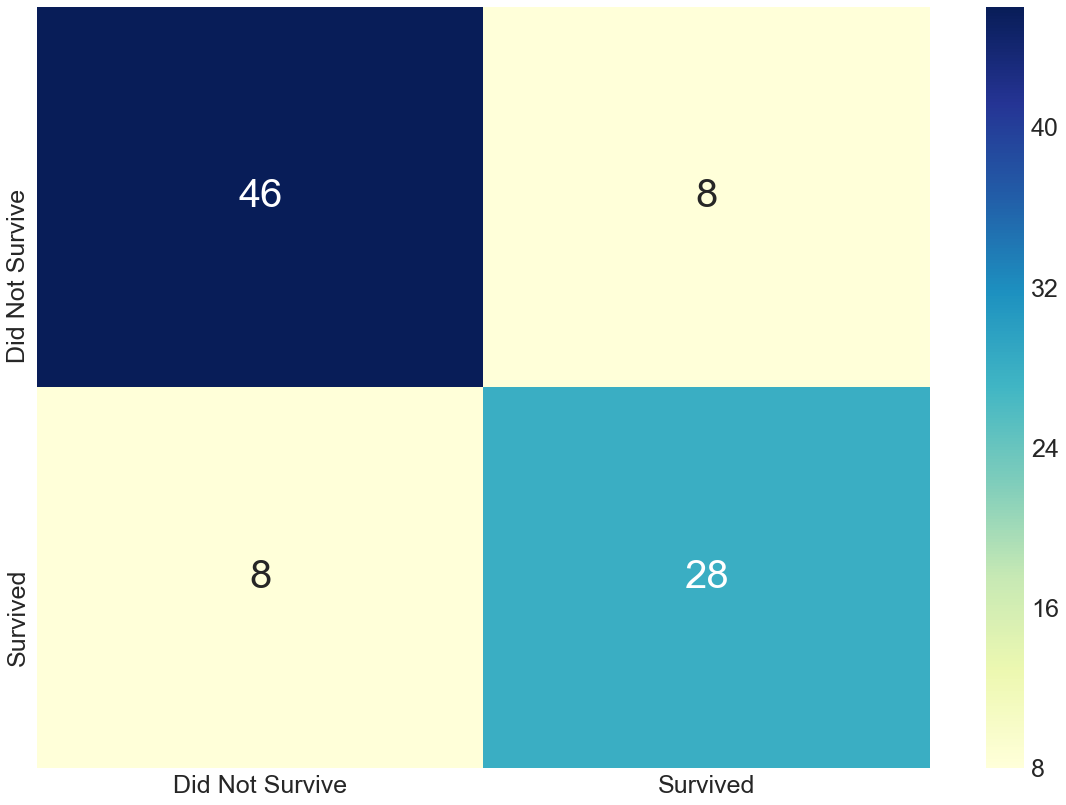

In [14]:
# plot confusion matrix
svm_model.plotConFusionMatrix(validate_features, validate_labels)

# Predict Survival on test set
### NOTE: Remember to scale the data

In [15]:
scaled_test_set = scale(test_data)
test_predictions = svm_model.predict(scaled_test_set)
print(test_predictions)

[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


# Create dataframe for test results
### 1. Create frame for test features
### 2. Create frame for predicted labels
### 3. Concatenate both frames

In [16]:
columns = ["PassengerId","Pclass","Name","Sex","Age","SibSp","Parch","Ticket","Fare","Cabin","Embarked"]
selected_columns = set(columns).difference(exclude)
test_features_df = pd.DataFrame(data = test_data, columns = [name for name in columns if name in selected_columns] )
test_labels_df = pd.DataFrame(data = test_predictions, columns = ["Survived_SVM"])
test_df = pd.concat([test_features_df, test_labels_df], axis = 1)
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked,Survived_SVM
0,2,1,39,0,0,1,0
1,2,0,55,1,0,2,1
2,1,1,71,0,0,1,0
3,2,1,28,0,0,2,0
4,2,0,21,1,1,2,1


# Dataframe of test data without feature transformation

In [17]:
test_features_raw_df = pd.read_csv("../titanic/test.csv", encoding = "UTF-8", delimiter = ","
                        ) 
test_df_raw = pd.concat([test_features_raw_df, test_labels_df], axis = 1)
test_df_raw.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_SVM
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


# Saving data to csv files

In [18]:
test_df_raw.to_csv("../test_predictions/test_SVM.csv", index = False)
submission = test_df_raw[["PassengerId", "Survived_SVM"]]
submission.rename(columns = {"Survived_SVM": "Survived"}, inplace = True)
submission.astype("int32")
submission.to_csv("../submissions/SVM_submission.csv", index = False)

# Changing some features to discrete data instead of continuous
# Changing Cabin, SibSp, and Parch to discrete true / false features

# Plotting the new correlation matrix


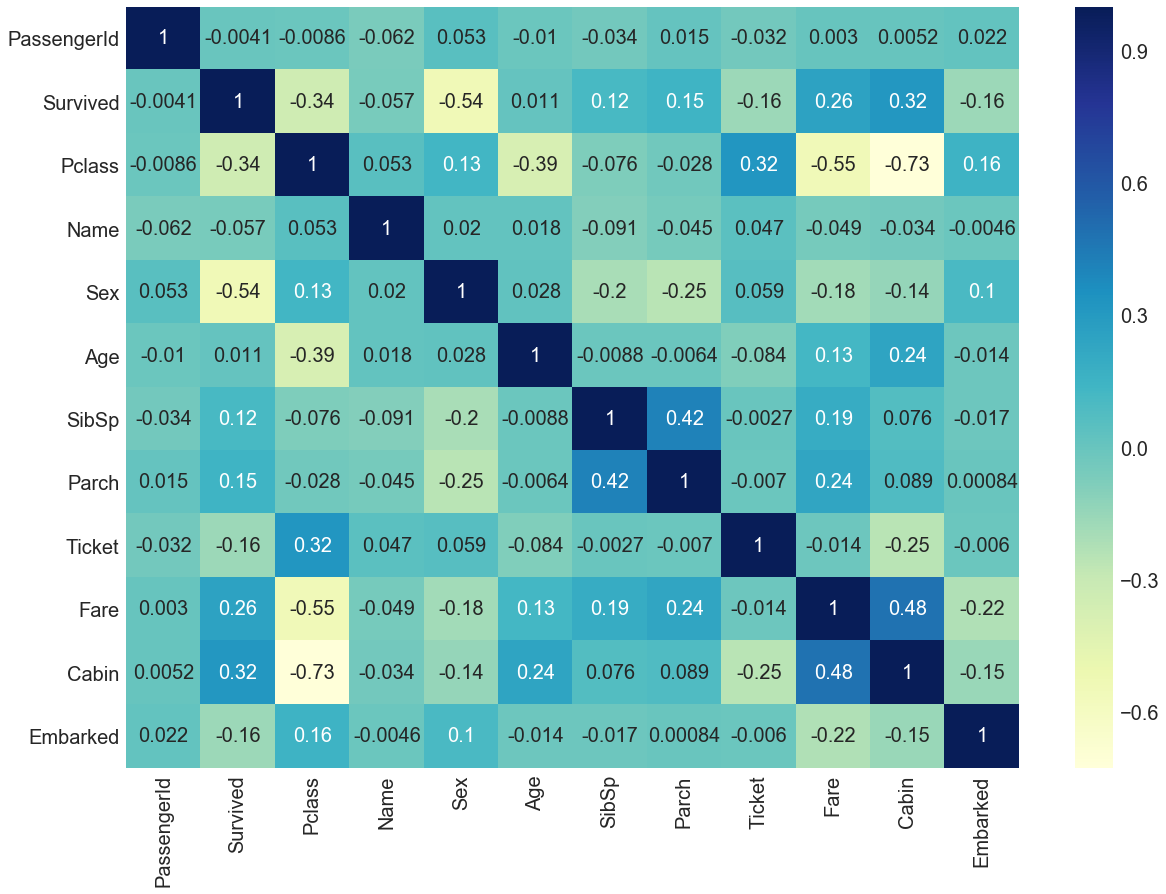

In [19]:
load_titanic_data.new_feature_correlation()

# Loading the new training and testing data


In [20]:
# load data
exclude = {"PassengerId", "Name", "Fare", "Ticket"}
train_data = load_titanic_data.new_train_data(drop_columns = exclude)
test_data = load_titanic_data.new_test_data(drop_columns = exclude)


New Training Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int32
Pclass      891 non-null int32
Sex         891 non-null int32
Age         891 non-null int32
SibSp       891 non-null int32
Parch       891 non-null int32
Cabin       891 non-null int32
Embarked    891 non-null int32
dtypes: int32(8)
memory usage: 27.9 KB
None

New Testing Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
Pclass      418 non-null int32
Sex         418 non-null int32
Age         418 non-null int32
SibSp       418 non-null int32
Parch       418 non-null int32
Cabin       418 non-null int32
Embarked    418 non-null int32
dtypes: int32(7)
memory usage: 11.5 KB
None


# Scaling the new data before training the model

In [21]:
# scale the data before performing grid search
scaled_features = scale(train_data["features"])

# Finding the best hyperparameters

In [22]:
# find best parameters for SVM using grid search
best_params = findBestParams(scaled_features, train_data["labels"])

best hyperparameters:	 {'C': 6, 'degree': 2, 'kernel': 'poly'}
best mean cross-validation score:	 0.8069675475488044


# Build the SVM model

In [23]:
# build SVM model based on best parameters
svm_model = MySVMClassifier(C = best_params['C'], kernel = best_params['kernel'], degree = best_params['degree'])

# Split data into training and validation set

In [24]:
# split data into training and validation set
train_features, validate_features, train_labels, validate_labels = train_test_split(
    scaled_features, train_data["labels"], random_state = 42, test_size = 0.1
)

# Train the SVM Model

In [25]:
# train model
svm_model.trainModel(train_features, train_labels)

Total Training Time:	0.10s


MySVMClassifier(C=6, break_ties=False, cache_size=200, class_weight=None,
                coef0=0.0, decision_function_shape='ovr', degree=2,
                gamma='scale', kernel='poly', max_iter=-1, probability=False,
                random_state=None, shrinking=True, tol=0.001, verbose=False)

# Determine model training performance

In [26]:
# training performance
svm_model.getTrainPerformance(train_features, train_labels)

The Accuracy of the SVM model is:	81.52%
The Precision of the SVM model is:	80.62%
The Recall of the SVM model is:	67.97%
The F1-Score of the SVM model is:	73.76%


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,

# Determine model validation performance

In [27]:
# test model
svm_model.getModelPerformance(validate_features, validate_labels)

The Accuracy of the SVM model is:	82.22%
The Precision of the SVM model is:	77.78%
The Recall of the SVM model is:	77.78%
The F1-Score of the SVM model is:	77.78%


array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0])

# Print the classification report

In [28]:
# print report
svm_model.printReport(validate_features, validate_labels)

Here is the classification report of the SVM Model:
                 precision    recall  f1-score   support

Did Not Survive       0.85      0.85      0.85        54
       Survived       0.78      0.78      0.78        36

       accuracy                           0.82        90
      macro avg       0.81      0.81      0.81        90
   weighted avg       0.82      0.82      0.82        90



# Plot the confusion matrix

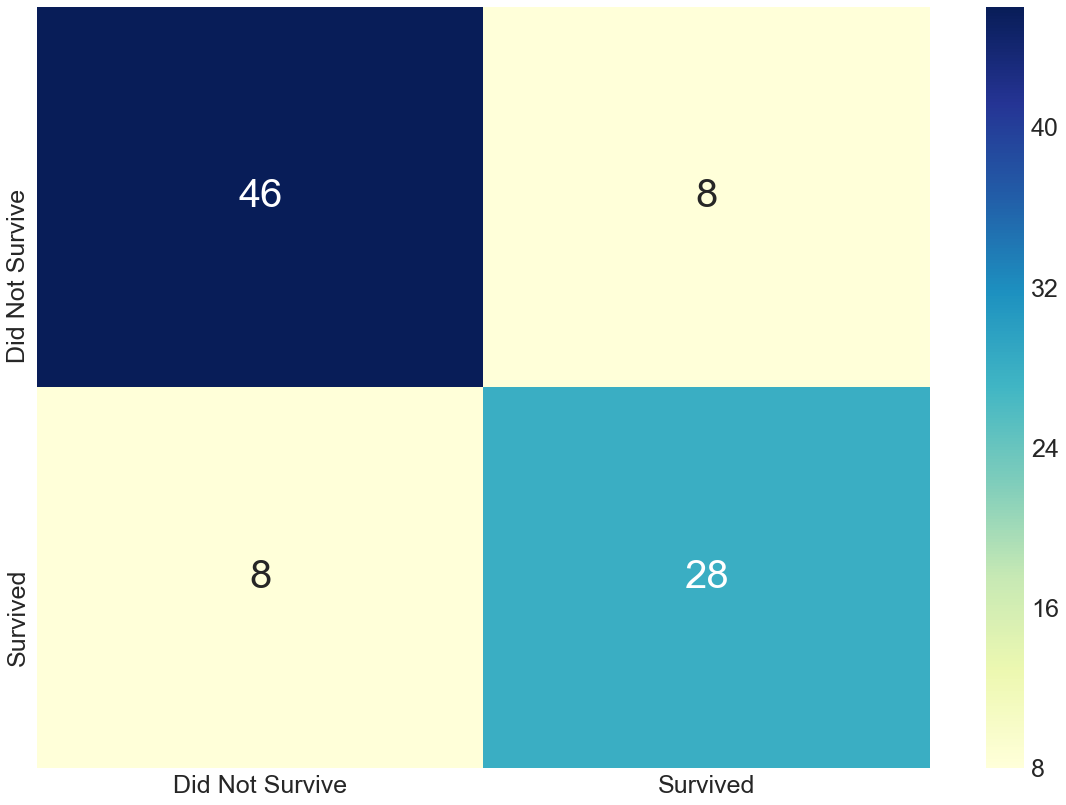

In [29]:
# plot confusion matrix
svm_model.plotConFusionMatrix(validate_features, validate_labels)

# Predict Survival on test set
### NOTE: Remember to scale the data

In [30]:
scaled_test_set = scale(test_data)
test_predictions = svm_model.predict(scaled_test_set)
print(test_predictions)

[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0
 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0
 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0
 1 1 0 1 1 1 0 1 0 0 0]


# Create dataframe for test results
### 1. Create frame for test features
### 2. Create frame for predicted labels
### 3. Concatenate both frames

In [31]:
columns = ["PassengerId","Pclass","Name","Sex","Age","SibSp","Parch","Ticket","Fare","Cabin","Embarked"]
selected_columns = set(columns).difference(exclude)
test_features_df = pd.DataFrame(data = test_data, columns = [name for name in columns if name in selected_columns] )
test_labels_df = pd.DataFrame(data = test_predictions, columns = ["Survived_SVM"])
test_df = pd.concat([test_features_df, test_labels_df], axis = 1)
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,Survived_SVM
0,2,1,39,0,0,0,1,0
1,2,0,55,1,0,0,2,0
2,1,1,71,0,0,0,1,0
3,2,1,28,0,0,0,2,0
4,2,0,21,1,1,0,2,0


# Dataframe of test data without feature transformation

In [32]:
test_features_raw_df = pd.read_csv("../titanic/test.csv", encoding = "UTF-8", delimiter = ","
                        ) 
test_df_raw = pd.concat([test_features_raw_df, test_labels_df], axis = 1)
test_df_raw.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_SVM
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


# Saving data to csv files

In [33]:
test_df_raw.to_csv("../test_predictions/new_test_SVM.csv", index = False)
submission = test_df_raw[["PassengerId", "Survived_SVM"]]
submission.rename(columns = {"Survived_SVM": "Survived"}, inplace = True)
submission.astype("int32")
submission.to_csv("../submissions/new_SVM_submission.csv", index = False)
 

# Feature transformation did not improve model performance
# In fact, it did not change model performance at all

# Counting number of survived and not survived labels

In [34]:
raw_data = pd.read_csv("../titanic/train.csv")
num_survived = len(raw_data[raw_data["Survived"] == 1]["Survived"])
num_not_survived = len(raw_data[raw_data["Survived"] == 0]["Survived"])
print("Number of Survived labels:", num_survived)
print("Number of Not Survived labels:", num_not_survived)
print("Not Survived: Survived ratio:", num_not_survived / num_survived)

Number of Survived labels: 342
Number of Not Survived labels: 549
Not Survived: Survived ratio: 1.605263157894737


# Number of not survived labels is almost double

# We will add duplicate survived passengers to balance data

# Loading the balanced training and testing data


In [35]:
# load data
exclude = {"PassengerId", "Name", "Fare", "Ticket", "Cabin"}
train_data = load_titanic_data.balanced_train_data(drop_columns = exclude)
test_data = load_titanic_data.test_data(drop_columns = exclude)


Training Set Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1233 entries, 0 to 889
Data columns (total 7 columns):
Survived    1233 non-null int32
Pclass      1233 non-null int32
Sex         1233 non-null int32
Age         1233 non-null int32
SibSp       1233 non-null int32
Parch       1233 non-null int32
Embarked    1233 non-null int32
dtypes: int32(7)
memory usage: 43.3 KB
None

Testing Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
Pclass      418 non-null int32
Sex         418 non-null int32
Age         418 non-null int32
SibSp       418 non-null int32
Parch       418 non-null int32
Embarked    418 non-null int32
dtypes: int32(6)
memory usage: 9.9 KB
None


# Scaling the balanced data before training the model

In [36]:
# scale the data before performing grid search
scaled_features = scale(train_data["features"])

# Finding the best hyperparameters

In [37]:
# find best parameters for SVM using grid search
best_params = findBestParams(scaled_features, train_data["labels"])

best hyperparameters:	 {'C': 31, 'degree': 2, 'kernel': 'rbf'}
best mean cross-validation score:	 0.8077943451499292


# Build the SVM model

In [38]:
# build SVM model based on best parameters
svm_model = MySVMClassifier(C = best_params['C'], kernel = best_params['kernel'], degree = best_params['degree'])

# Split data into training and validation set

In [39]:
# split data into training and validation set
train_features, validate_features, train_labels, validate_labels = train_test_split(
    scaled_features, train_data["labels"], random_state = 42, test_size = 0.1
)

# Train the SVM Model

In [40]:
# train model
svm_model.trainModel(train_features, train_labels)

Total Training Time:	0.30s


MySVMClassifier(C=31, break_ties=False, cache_size=200, class_weight=None,
                coef0=0.0, decision_function_shape='ovr', degree=2,
                gamma='scale', kernel='rbf', max_iter=-1, probability=False,
                random_state=None, shrinking=True, tol=0.001, verbose=False)

# Determine model training performance

In [41]:
# training performance
svm_model.getTrainPerformance(train_features, train_labels)

The Accuracy of the SVM model is:	84.22%
The Precision of the SVM model is:	87.16%
The Recall of the SVM model is:	83.58%
The F1-Score of the SVM model is:	85.33%


array([0, 1, 0, ..., 1, 0, 1])

# Determine model validation performance

In [42]:
# test model
svm_model.getModelPerformance(validate_features, validate_labels)

The Accuracy of the SVM model is:	80.65%
The Precision of the SVM model is:	88.06%
The Recall of the SVM model is:	78.67%
The F1-Score of the SVM model is:	83.10%


array([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1])

# Print the classification report

In [43]:
# print report
svm_model.printReport(validate_features, validate_labels)

Here is the classification report of the SVM Model:
                 precision    recall  f1-score   support

Did Not Survive       0.72      0.84      0.77        49
       Survived       0.88      0.79      0.83        75

       accuracy                           0.81       124
      macro avg       0.80      0.81      0.80       124
   weighted avg       0.82      0.81      0.81       124



# Plot the confusion matrix

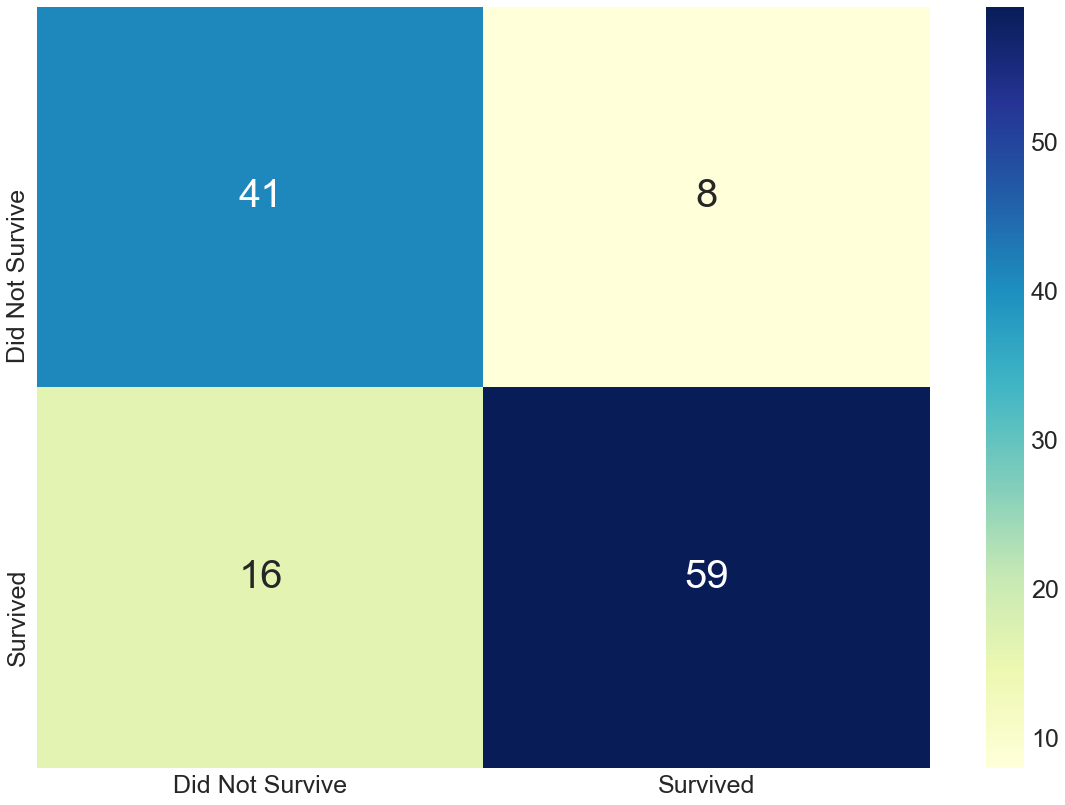

In [44]:
# plot confusion matrix
svm_model.plotConFusionMatrix(validate_features, validate_labels)

# Predict Survival on test set
### NOTE: Remember to scale the data

In [45]:
scaled_test_set = scale(test_data)
test_predictions = svm_model.predict(scaled_test_set)
print(test_predictions)

[0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1
 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1
 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0
 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0
 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0
 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0
 0 1 1 1 1 1 0 1 0 0 1]


# Create dataframe for test results
### 1. Create frame for test features
### 2. Create frame for predicted labels
### 3. Concatenate both frames

In [46]:
columns = ["PassengerId","Pclass","Name","Sex","Age","SibSp","Parch","Ticket","Fare","Cabin","Embarked"]
selected_columns = set(columns).difference(exclude)
test_features_df = pd.DataFrame(data = test_data, columns = [name for name in columns if name in selected_columns] )
test_labels_df = pd.DataFrame(data = test_predictions, columns = ["Survived_SVM"])
test_df = pd.concat([test_features_df, test_labels_df], axis = 1)
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked,Survived_SVM
0,2,1,39,0,0,1,0
1,2,0,55,1,0,2,1
2,1,1,71,0,0,1,0
3,2,1,28,0,0,2,0
4,2,0,21,1,1,2,1


# Dataframe of test data without feature transformation

In [47]:
test_features_raw_df = pd.read_csv("../titanic/test.csv", encoding = "UTF-8", delimiter = ","
                        ) 
test_df_raw = pd.concat([test_features_raw_df, test_labels_df], axis = 1)
test_df_raw.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_SVM
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


# Saving data to csv files

In [48]:
test_df_raw.to_csv("../test_predictions/balanced_test_SVM.csv", index = False)
submission = test_df_raw[["PassengerId", "Survived_SVM"]]
submission.rename(columns = {"Survived_SVM": "Survived"}, inplace = True)
submission.astype("int32")
submission.to_csv("../submissions/balanced_SVM_submission.csv", index = False)

# Model precision has increased, but recall has dropped
